# LendingClub Loans Data

I'm using 2 csv files
1. accepted_2007_to_2018Q4.csv (too large to upload to git so url here : https://www.kaggle.com/datasets/wordsforthewise/lending-club/data)
2. LCDataDictionary.csv (uploaded to github)

The final goal is to build a model that can predict loan default with the data available at the time of applications.

In [1]:
#package import

import pandas as pd
import matplotlib.pyplot as plt


**Data Loading**

In [2]:
#load dataset
accepted_df = pd.read_csv('data/raw/accepted_2007_to_2018Q4.csv')

/var/folders/n_/95rcqzx91d1bf_zbx38smk080000gn/T/ipykernel_31871/962645636.py:2: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('data/raw/accepted_2007_to_2018Q4.csv')


In [3]:
data_dictionary = pd.read_csv('data/raw/LCDataDictionary.csv')

In [169]:
# explore df



accepted_df = accepted_df.reindex(sorted(accepted_df.columns), axis=1)

accepted_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    acc_now_delinq                              2260639 non-null  float64
 1    acc_open_past_24mths                        2210638 non-null  float64
 2    addr_state                                  2260668 non-null  object 
 3    all_util                                    1394320 non-null  float64
 4    annual_inc                                  2260664 non-null  float64
 5    annual_inc_joint                            120710 non-null   float64
 6    application_type                            2260668 non-null  object 
 7    avg_cur_bal                                 2190322 non-null  float64
 8    bc_open_to_buy                              2185733 non-null  float64
 9    bc_util                                     

# Determine Target Variable

In [170]:
# Using intuition, review the columns that are likely to have the outcome of the loans, such as default.

accepted_df['loan_status'].unique()


array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

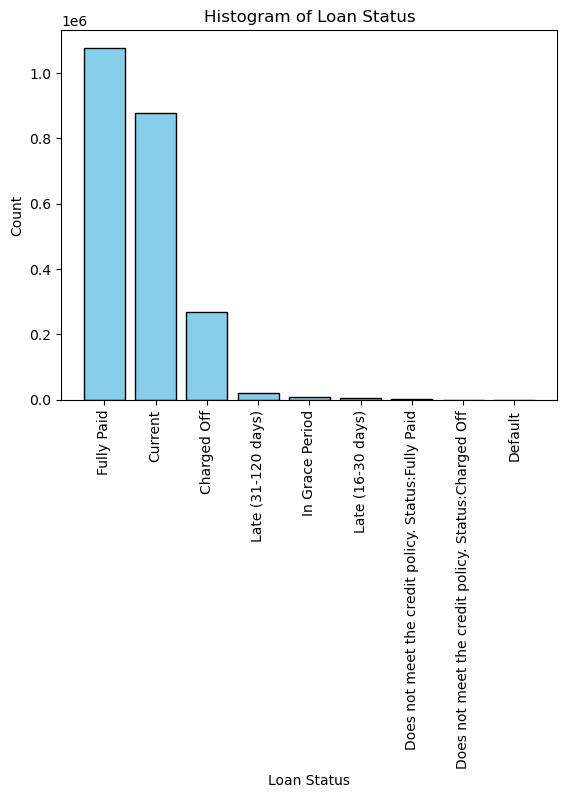

In [171]:
# Count the occurrences of each unique value in 'loan_status'
value_counts = accepted_df['loan_status'].value_counts()

# Create a bar plot to visualize the counts
plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Histogram of Loan Status')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


In [172]:
len(accepted_df)

2260701

In [173]:
# almost 0.9M records are of loans still being paid off, so I can't use them for predicting the final outcome. I will remove them.

# Also removing all other statuses except for Fully Paid and Charged Off for simplicity.

# Values to be excluded from the 'loan_status' column
keep_statuses = ['Fully Paid', 'Charged Off']

# Create a condition to select records that do not have these values
condition = accepted_df['loan_status'].isin(keep_statuses)

# Apply the condition to the DataFrame to remove records with those values
comp_loan_df = accepted_df[condition]


In [174]:
# Remaining records that are complete

len(comp_loan_df)

1345310

In [175]:
# 0.9M 'current' records are taken out

len(accepted_df)-len(comp_loan_df)

915391

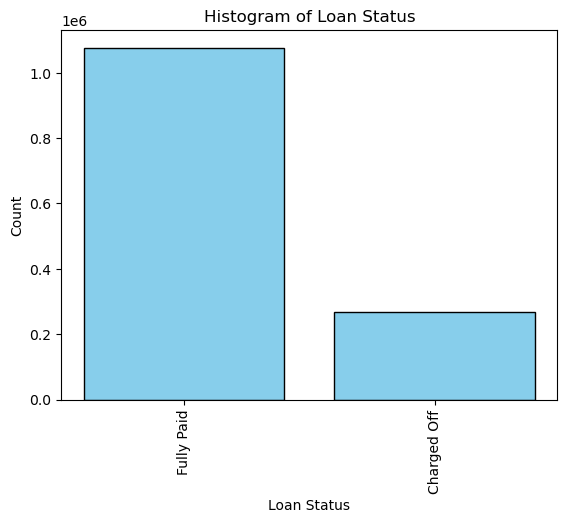

In [176]:
# Re-vizualize the loan_status with 'Current' removed
value_counts = comp_loan_df['loan_status'].value_counts()

# Create a bar plot to visualize the counts
plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Histogram of Loan Status')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [177]:
paid = (comp_loan_df['loan_status'] == "Fully Paid").sum()

paid_pct = round(paid/len(comp_loan_df)*100, 0)

defaulted = (comp_loan_df['loan_status'] == "Charged Off").sum()

defaulted_pct = round(defaulted/len(comp_loan_df)*100, 0)

print('Fully Paid : Charged Off = ' + str(paid_pct) + ' : ' + str(defaulted_pct))

Fully Paid : Charged Off = 80.0 : 20.0


# Column Selection for Modeling

In [178]:
# Many of the columns hold data that will not be available at the time a loan application is made, such as 'next_pymnt_date', so I'm using my intuition to keep only the columns that seem likely to be available at the application stage.

app_columns = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'delinq_2yrs', 'delinq_amnt',\
               'desc', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_title', 'fico_range_high', 'fico_range_low',\
              'home_ownership', 'id','inq_fi', 'inq_last_12m', 'inq_last_6mths', 'loan_amnt', \
              'mo_sin_old_il_acct', 'max_bal_bc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'collections_12_mths_ex_med',\
              'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq',\
               'mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il','mths_since_recent_bc',\
               'mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq', \
               'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl',\
               'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',\
               'num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_acc_6m','open_il_12m','open_il_24m',\
               'open_rv_12m','open_rv_24m','percent_bc_gt_75','pub_rec','pub_rec_bankruptcies',\
               'purpose', 'revol_bal','revol_util', 'tax_liens', 'tot_coll_amt','tot_cur_bal','tot_hi_cred_lim',\
               'total_acc','total_bal_ex_mort','total_bal_il','total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim',\
              'verification_status','verification_status_joint','zip_code']

# Create a new df that only includes above columns

app_df = comp_loan_df[app_columns]

In [179]:
app_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 76 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   addr_state                      1345310 non-null  object 
 1   annual_inc                      1345310 non-null  float64
 2   annual_inc_joint                25800 non-null    float64
 3   application_type                1345310 non-null  object 
 4   delinq_2yrs                     1345310 non-null  float64
 5   delinq_amnt                     1345310 non-null  float64
 6   desc                            123532 non-null   object 
 7   dti                             1344936 non-null  float64
 8   dti_joint                       25797 non-null    float64
 9   earliest_cr_line                1345310 non-null  object 
 10  emp_title                       1259525 non-null  object 
 11  fico_range_high                 1345310 non-null  float64
 12  

# **Summarize Missing Value Stats by Column**

**First Organize missing values by column names into a Dictionary**

In [180]:
#create a df with two columns: column names, # of missing value

#create a list containing names of the columns first

column_names = app_df.columns.tolist()

# create a function that takes the list of column names and returns the number of missing values per column

def count_missing_values(data, columns):
    """
    Count the number of missing values in the specified columns of a DataFrame.
    
    Args:
    data (pandas.DataFrame): The DataFrame containing the data.
    columns (list of str): A list of column names to count missing values in.
    
    Returns:
    dict: A dictionary where keys are column names, and values are the counts of missing values.
    """
    missing_counts = {}
    
    for column in column_names:
        missing_count = data[column].isnull().sum()
        missing_counts[column] = missing_count
    
    return missing_counts

# run the function and store the resulting dict as missing_counts

missing_counts = count_missing_values(app_df, column_names)


**Vizualize columns with missing values**

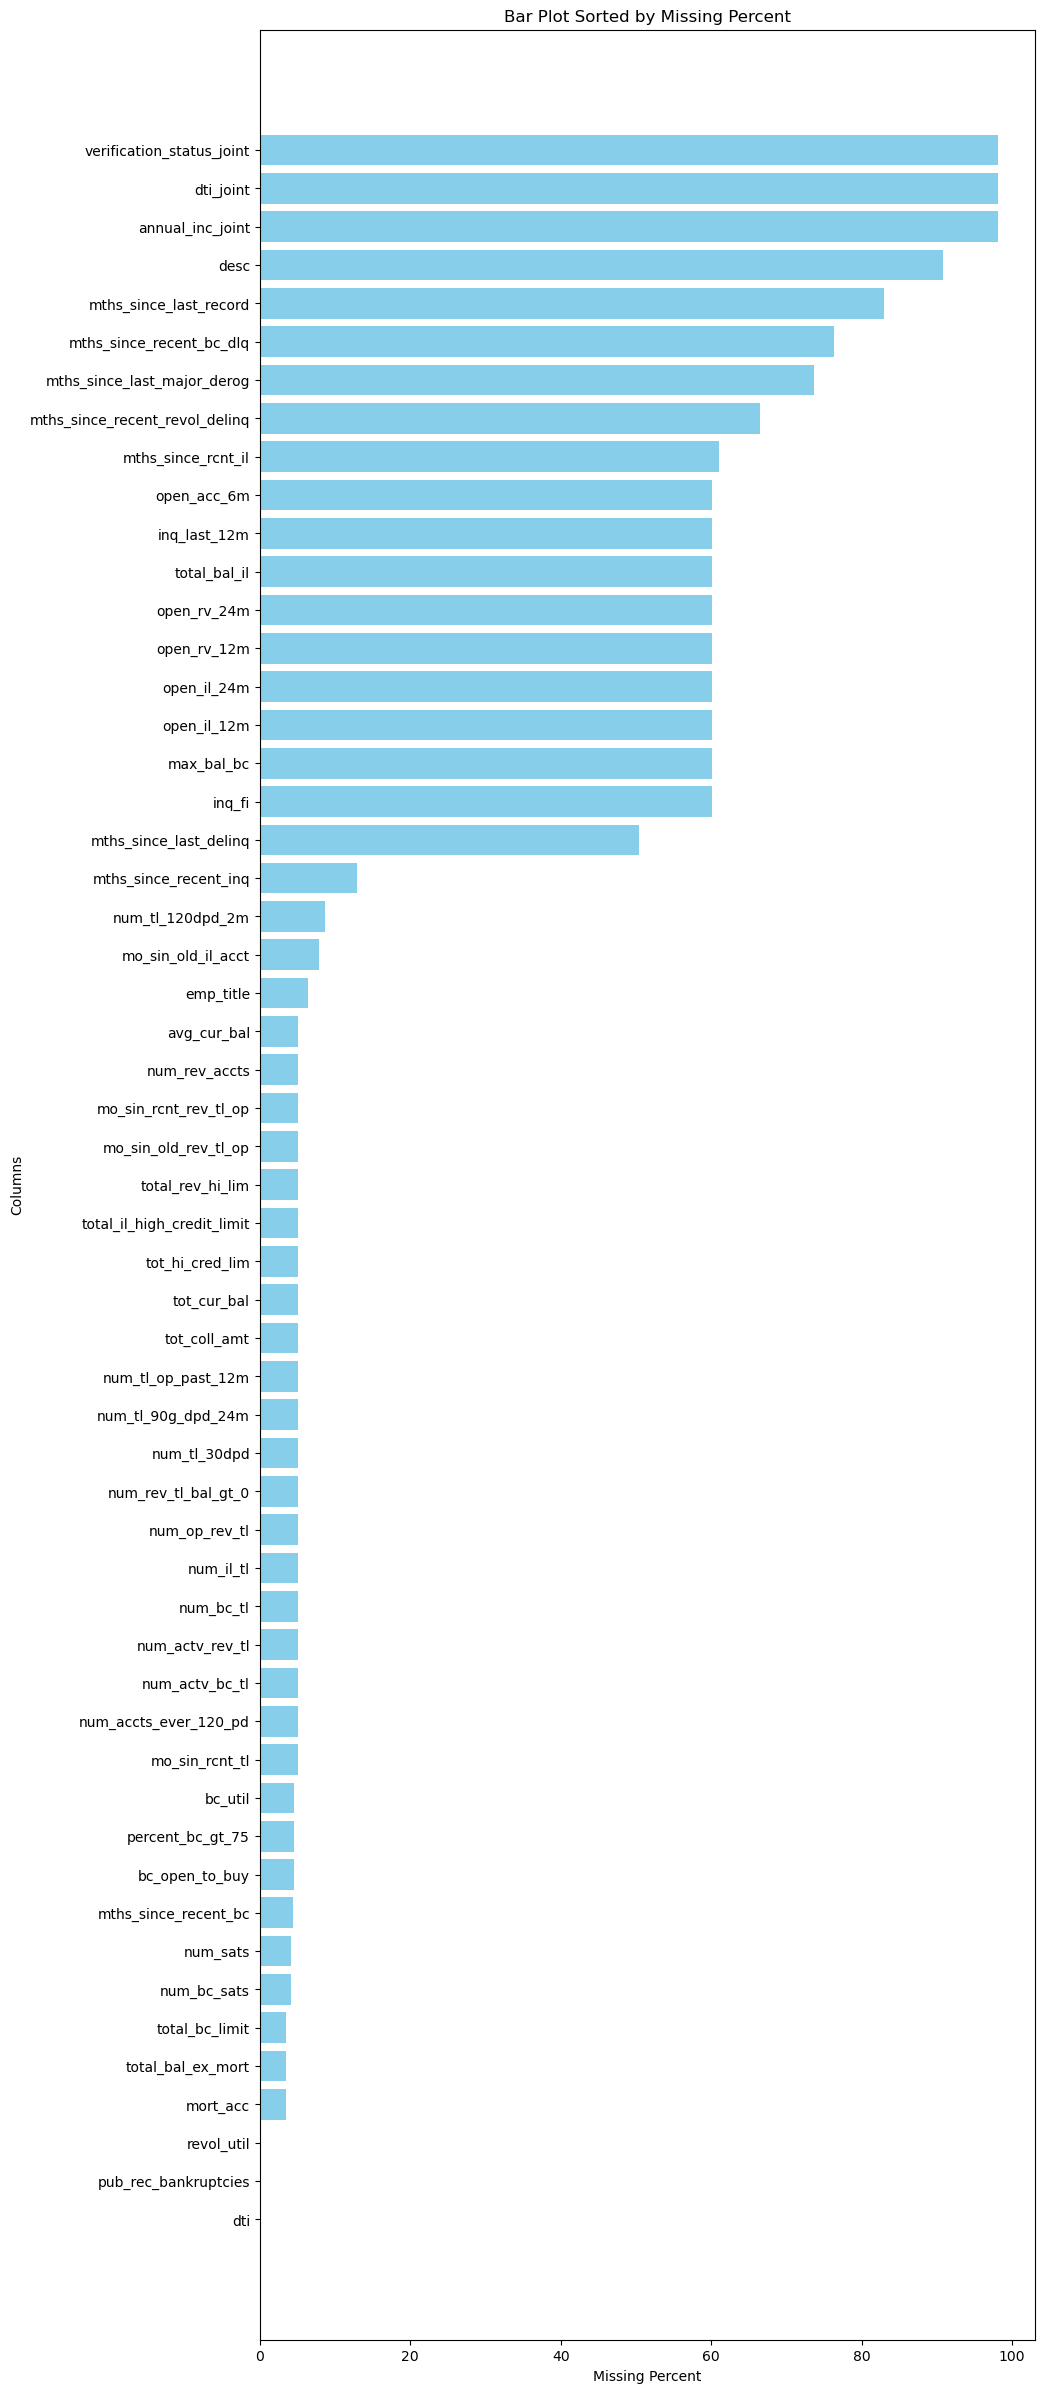

In [181]:

# create bar plot sorted by number of missing values per column

# Sort the dictionary by values in descending order
missing_counts = dict(sorted(missing_counts.items(), key=lambda item: item[1], reverse=False))

# remove columns with 0 missing data

missing_counts = {key: value for key, value in missing_counts.items() if value > 0}

# Extract the sorted keys and values
columns = list(missing_counts.keys())
counts = list(missing_counts.values())
              
# Creat a list of missing value %

percents = []

for number in counts:
    percent = round(number/len(app_df['id'])*100, 2)
    percents.append(percent)

# Zip columns and percents

missing_pct = dict(zip(columns, percents))

#Sort by percents in descending order

missing_pct = dict(sorted(missing_pct.items(), key=lambda item: item[1], reverse=False))

# Remove 0 missing pct

non0_missing_pct = {key: value for key, value in missing_pct.items() if value != 0}

non0_missing_pct_columns = list(non0_missing_pct.keys())
non0_missing_pct_counts = list(non0_missing_pct.values())

# Create a bar plot
plt.figure(figsize=(10, 30))  # Adjust the figure size if needed
plt.barh(non0_missing_pct_columns, non0_missing_pct_counts, color='skyblue')

# Add labels and title
plt.xlabel('Missing Percent')
plt.ylabel('Columns')
plt.title('Bar Plot Sorted by Missing Percent')

# Show the plot
plt.show()



**Notice there are sets of column name, each having the same amounts of missing values. This migth mean that the said columns may be related to each other and apply to the same loan 'id'.**

Next I want to group the columns by the percentage of missing values, so that I can look at the relevant columns together.

In [182]:
missing_pct_df = pd.DataFrame.from_dict(non0_missing_pct, orient='index', columns=['missing_pct']).reset_index()
missing_pct_df.columns = ['Columns', 'missing_pct']

missing_pct_df = missing_pct_df.sort_values(by='missing_pct', ascending=False)

# Group the DataFrame by unique values in the 'missing_pct' column
grouped = missing_pct_df.groupby('missing_pct')

# Iterate through the groups and display them
for missing_pct, group in grouped:
    print(group)
    print()


  Columns  missing_pct
0     dti         0.03

                Columns  missing_pct
1  pub_rec_bankruptcies         0.05

      Columns  missing_pct
2  revol_util         0.06

             Columns  missing_pct
5     total_bc_limit         3.51
4  total_bal_ex_mort         3.51
3           mort_acc         3.51

       Columns  missing_pct
7     num_sats         4.15
6  num_bc_sats         4.15

                Columns  missing_pct
8  mths_since_recent_bc         4.48

          Columns  missing_pct
9  bc_open_to_buy         4.54

             Columns  missing_pct
10  percent_bc_gt_75         4.58

    Columns  missing_pct
11  bc_util          4.6

                       Columns  missing_pct
28        mo_sin_old_rev_tl_op         5.02
31                 avg_cur_bal         5.02
30               num_rev_accts         5.02
29       mo_sin_rcnt_rev_tl_op         5.02
27            total_rev_hi_lim         5.02
14              num_actv_bc_tl         5.02
19         num_rev_tl_bal_gt_0     

# Investigating Missing Value Columns (most missing to least missing)

In [183]:
# verification_status_joint

print(app_df['verification_status_joint'].unique())

print('Null value in ' + str(app_df['verification_status_joint'].isnull().sum()) + ' records') 

[nan 'Not Verified' 'Verified' 'Source Verified']
Null value in 1319715 records


In [184]:
# maybe NAN occurs only for loans not applied jointly

# Explore application_type

print(app_df['application_type'].unique())

print('Null value in ' + str(app_df['application_type'].isnull().sum()) + ' records') 

print('There are '+ str((app_df['application_type'] != 'Joint App').sum()) +' non-Joint Applications.')


['Individual' 'Joint App']
Null value in 0 records
There are 1319510 non-Joint Applications.


In [185]:
# the number of non joint apps closely match number of 'nan' in 'verification_status_joint'. Let's check id overlap.

vsj_nan = set(app_df.loc[app_df['verification_status_joint'].isnull(), 'id'])

apptype_notjoint = set(app_df.loc[app_df['application_type'] != 'Joint App', 'id'])

intersection_set = vsj_nan.intersection(apptype_notjoint)

print(len(intersection_set))

print(len(intersection_set)/(app_df['verification_status_joint'].isnull().sum())*100)

#99.98% of nan values in 'Verification_status_joint' can indeed be explained by those apps not being joint applications.



1319510
99.98446634311196


In [186]:
# impute these with 'Not Joint App'

# create a copy of app_df, app_imp, which will hold new df with imputed data and impute

app_imp = app_df.copy()

app_imp['verification_status_joint'].fillna('Not Joint App', inplace=True)

print(app_imp['verification_status_joint'].isna().sum())

0


In [187]:
# annual_inc_joint and dti_joint can likely be explained in the same way as above.

# impute zero using a new function

def zero_impute(column_name):
    app_imp[column_name].fillna(0, inplace=True)
    
zero_impute('annual_inc_joint')
zero_impute('dti_joint')

In [188]:
# check imputation

print(app_imp['annual_inc_joint'].isna().sum())
print(app_imp['dti_joint'].isna().sum())

0
0


In [189]:
# desc is missing 90% of the time, and it's a self reported field by the borrower. Dropping this.

app_imp = app_imp.drop('desc', axis=1)


In [190]:
# 'mths_since_last_record' missing 82.98%

# write a dictionary function to query easily

def define(column_name):
    try:
        description = data_dictionary.loc[data_dictionary['LoanStatNew'] == column_name, 'Description'].values[0]
        return description
    except IndexError:
        return "Description not found for the given column name."

print(define('mths_since_last_record'))

The number of months since the last public record.


In [191]:
app_imp['mths_since_last_record'].describe()

count    228555.000000
mean         70.637120
std          26.579224
min           0.000000
25%          53.000000
50%          72.000000
75%          90.000000
max         129.000000
Name: mths_since_last_record, dtype: float64

In [192]:
#It seems plausible that ~83% of applicants didn't have any public record ever. May impute these Nulls with a value much larger than max value here.

# Imputing these with 999 months (83.25 years) to signify that these applicants never had public records against them.

app_imp['mths_since_last_record'].fillna(999, inplace=True)

In [193]:
# Same thought as above for other missing value columns that start with "mths since" negative credit events

mths = ['mths_since_rcnt_il','mths_since_recent_revol_delinq','mths_since_last_major_derog','mths_since_recent_bc_dlq',\
       'mths_since_recent_inq', 'mths_since_last_delinq','mo_sin_old_il_acct']

for column in mths:
    print(app_imp[column].describe())

count    523382.000000
mean         19.592967
std          24.871717
min           0.000000
25%           6.000000
50%          12.000000
75%          22.000000
max         511.000000
Name: mths_since_rcnt_il, dtype: float64
count    449962.000000
mean         35.804695
std          22.428202
min           0.000000
25%          17.000000
50%          33.000000
75%          52.000000
max         202.000000
Name: mths_since_recent_revol_delinq, dtype: float64
count    353750.000000
mean         43.701165
std          21.378476
min           0.000000
25%          27.000000
50%          44.000000
75%          61.000000
max         226.000000
Name: mths_since_last_major_derog, dtype: float64
count    319020.000000
mean         39.652617
std          22.698164
min           0.000000
25%          21.000000
50%          38.000000
75%          58.000000
max         202.000000
Name: mths_since_recent_bc_dlq, dtype: float64
count    1.171239e+06
mean     6.713209e+00
std      5.849949e+00
min    

In [194]:
# looks like the original dataset was imputed with 999 too. Making that the default for nan values in months_since columns.

def mths_impute(column):
    app_imp[column].fillna(999, inplace=True)
    
for column in mths:
    mths_impute(column)

for column in mths:
    print("missing in " + column + " : "+ str(app_imp[column].isna().sum()))

missing in mths_since_rcnt_il : 0
missing in mths_since_recent_revol_delinq : 0
missing in mths_since_last_major_derog : 0
missing in mths_since_recent_bc_dlq : 0
missing in mths_since_recent_inq : 0
missing in mths_since_last_delinq : 0
missing in mo_sin_old_il_acct : 0


In [195]:
for column in mths:
    print("max value in " + column + " : "+ str(app_imp[column].max()))

max value in mths_since_rcnt_il : 999.0
max value in mths_since_recent_revol_delinq : 999.0
max value in mths_since_last_major_derog : 999.0
max value in mths_since_recent_bc_dlq : 999.0
max value in mths_since_recent_inq : 999.0
max value in mths_since_last_delinq : 999.0
max value in mo_sin_old_il_acct : 999.0


In [196]:
# several columns missing identical 60.12% of vlaues

missing_60 = (missing_pct_df.loc[missing_pct_df['missing_pct'] == 60.04, 'Columns'])

print(missing_60)


41     open_rv_12m
37          inq_fi
38      max_bal_bc
39     open_il_12m
40     open_il_24m
42     open_rv_24m
43    total_bal_il
44    inq_last_12m
45     open_acc_6m
Name: Columns, dtype: object


In [197]:
for column in missing_60:
    print(app_imp[column].describe())

count    537598.000000
mean          1.420885
std           1.574845
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          28.000000
Name: open_rv_12m, dtype: float64
count    537598.000000
mean          1.093306
std           1.586263
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          48.000000
Name: inq_fi, dtype: float64
count    537598.000000
mean       5537.703496
std        5471.949360
min           0.000000
25%        2180.000000
50%        4201.000000
75%        7198.750000
max      776843.000000
Name: max_bal_bc, dtype: float64
count    537598.000000
mean          0.776366
std           0.993202
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          25.000000
Name: open_il_12m, dtype: float64
count    537598.000000
mean          1.742754
std           1.685722
min           0.000000
25%           1.000000
50%           1.000

In [198]:
# These seem to be related attributes about number of installment and revolving credit accounts and associate credit inquiries and credit balance

# Nulls in these can be imputed with 0

for column in missing_60:
    zero_impute(column)

In [199]:
# Check if any columns in missing_60 are still missing any values

def count_nan(column_name):
    print(column_name + ' : ' + str(app_imp[column_name].isna().sum()))

for column in missing_60:
    count_nan(column)



open_rv_12m : 0
inq_fi : 0
max_bal_bc : 0
open_il_12m : 0
open_il_24m : 0
open_rv_24m : 0
total_bal_il : 0
inq_last_12m : 0
open_acc_6m : 0


In [200]:
#num_tl_120dpd_2m missing 8.73%

print(define('num_tl_120dpd_2m'))

print(app_df['num_tl_120dpd_2m'].unique())

print(app_df['num_tl_120dpd_2m'].describe())

Number of accounts currently 120 days past due (updated in past 2 months)
[ 0. nan  1.  2.  6.  3.  4.]
count    1.227909e+06
mean     8.200933e-04
std      3.049884e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: num_tl_120dpd_2m, dtype: float64


In [201]:
#impute nan with 0 as mode

zero_impute('num_tl_120dpd_2m')

print(app_imp['num_tl_120dpd_2m'].unique())


[0. 1. 2. 6. 3. 4.]


In [202]:
# emp_title missing 6.38%. Impute 'Unknown' for nan

app_imp['emp_title'].fillna('Unknown', inplace=True)

count_nan('emp_title')

emp_title : 0


In [203]:
# A bunch of columns are missing 5.02% of records. Likely related to each other

missing_5 = missing_pct_df.loc[missing_pct_df['missing_pct']== 5.02, 'Columns']

print(columns)

['inq_last_6mths', 'zip_code', 'tax_liens', 'collections_12_mths_ex_med', 'dti', 'pub_rec_bankruptcies', 'revol_util', 'mort_acc', 'total_bal_ex_mort', 'total_bc_limit', 'num_bc_sats', 'num_sats', 'mths_since_recent_bc', 'bc_open_to_buy', 'percent_bc_gt_75', 'bc_util', 'mo_sin_rcnt_tl', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'avg_cur_bal', 'emp_title', 'mo_sin_old_il_acct', 'num_tl_120dpd_2m', 'mths_since_recent_inq', 'mths_since_last_delinq', 'inq_fi', 'max_bal_bc', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'inq_last_12m', 'open_acc_6m', 'mths_since_rcnt_il', 'mths_since_recent_revol_delinq', 'mths_since_last_major_derog', 'mths_since_recent_

In [204]:
for column in missing_5:
    print(column + ': '+ define(column))

# They all seem to be columns related to applicants open account information reported in their credit report


mo_sin_old_rev_tl_op: Months since oldest revolving account opened
avg_cur_bal: Average current balance of all accounts
num_rev_accts: Number of revolving accounts
mo_sin_rcnt_rev_tl_op: Months since most recent revolving account opened
total_rev_hi_lim: Description not found for the given column name.
num_actv_bc_tl: Number of currently active bankcard accounts
num_rev_tl_bal_gt_0: Number of revolving trades with balance >0
mo_sin_rcnt_tl: Months since most recent account opened
num_accts_ever_120_pd: Number of accounts ever 120 or more days past due
total_il_high_credit_limit: Total installment high credit/credit limit
num_bc_tl: Number of bankcard accounts
num_il_tl: Number of installment accounts
num_op_rev_tl: Number of open revolving accounts
num_actv_rev_tl: Number of currently active revolving trades
num_tl_30dpd: Number of accounts currently 30 days past due (updated in past 2 months)
num_tl_90g_dpd_24m: Number of accounts 90 or more days past due in last 24 months
num_tl_op_p

In [205]:
for column in missing_5:
    print(define(column))
    print(app_imp[column].describe())

Months since oldest revolving account opened
count    1.277782e+06
mean     1.814760e+02
std      9.450512e+01
min      2.000000e+00
25%      1.170000e+02
50%      1.640000e+02
75%      2.300000e+02
max      8.520000e+02
Name: mo_sin_old_rev_tl_op, dtype: float64
Average current balance of all accounts
count    1.277761e+06
mean     1.348861e+04
std      1.628970e+04
min      0.000000e+00
25%      3.101000e+03
50%      7.407000e+03
75%      1.871700e+04
max      9.580840e+05
Name: avg_cur_bal, dtype: float64
Number of revolving accounts
count    1.277782e+06
mean     1.461034e+01
std      8.119309e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.300000e+01
75%      1.900000e+01
max      1.280000e+02
Name: num_rev_accts, dtype: float64
Months since most recent revolving account opened
count    1.277782e+06
mean     1.311569e+01
std      1.634105e+01
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.600000e+01
max      4.380000e+02
Name: mo_sin_rcnt_r

In [206]:
# Months_since columns can be imputed with 999 again

# separate missing_5 columns by months_since types and the rest

missing_5_mths = [item for item in missing_5 if "mo_sin" in item]

print(missing_5_mths)
    

['mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']


In [207]:
# impute these with 999 too

for column in missing_5_mths:
    mths_impute(column)
    print('missing in ' + column + ': ' + str(app_imp[column].isna().sum()))

missing in mo_sin_old_rev_tl_op: 0
missing in mo_sin_rcnt_rev_tl_op: 0
missing in mo_sin_rcnt_tl: 0


In [208]:
# separate num_ types to impute with zeroes

missing_5_num = [item for item in missing_5 if "num_" in item]

print(missing_5_num)

['num_rev_accts', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0', 'num_accts_ever_120_pd', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_actv_rev_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m']


In [209]:
# zero impute

for column in missing_5_num:
    zero_impute(column)
    print('missing in ' + column + ': ' + str(app_imp[column].isna().sum()))

missing in num_rev_accts: 0
missing in num_actv_bc_tl: 0
missing in num_rev_tl_bal_gt_0: 0
missing in num_accts_ever_120_pd: 0
missing in num_bc_tl: 0
missing in num_il_tl: 0
missing in num_op_rev_tl: 0
missing in num_actv_rev_tl: 0
missing in num_tl_30dpd: 0
missing in num_tl_90g_dpd_24m: 0
missing in num_tl_op_past_12m: 0


In [210]:
# impute the rest of column types in missing_5

missing_5_rest = sorted([item for item in missing_5 if item not in missing_5_num and item not in missing_5_mths])

print(missing_5_rest)


['avg_cur_bal', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_il_high_credit_limit', 'total_rev_hi_lim']


In [211]:
for column in missing_5_rest:
    print(define(column))
    print(app_imp[column].describe())

Average current balance of all accounts
count    1.277761e+06
mean     1.348861e+04
std      1.628970e+04
min      0.000000e+00
25%      3.101000e+03
50%      7.407000e+03
75%      1.871700e+04
max      9.580840e+05
Name: avg_cur_bal, dtype: float64
Total collection amounts ever owed
count    1.277783e+06
mean     2.493859e+02
std      1.106497e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
Total current balance of all accounts
count    1.277783e+06
mean     1.411338e+05
std      1.575478e+05
min      0.000000e+00
25%      2.942300e+04
50%      8.023100e+04
75%      2.107150e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
Total high credit/credit limit
count    1.277783e+06
mean     1.743878e+05
std      1.780961e+05
min      0.000000e+00
25%      4.962050e+04
50%      1.123730e+05
75%      2.520760e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64
Total insta

In [212]:
# Zero impute seems reasonable

for column in missing_5_rest:
    zero_impute(column)
    print('Missing in ' + column + ': ' + str(app_imp[column].isna().sum()))

Missing in avg_cur_bal: 0
Missing in tot_coll_amt: 0
Missing in tot_cur_bal: 0
Missing in tot_hi_cred_lim: 0
Missing in total_il_high_credit_limit: 0
Missing in total_rev_hi_lim: 0


In [213]:
# View remaining columns with missing values in app_imp

column_names = app_imp.columns.tolist()

missing_app_imp = count_missing_values(app_imp, column_names)

missing_app_imp = {key: value for key, value in missing_app_imp.items() if value != 0}

missing_app_imp = dict(sorted(missing_app_imp.items(), key=lambda item: item[1], reverse=True))

missing_app_imp

{'bc_util': 61912,
 'percent_bc_gt_75': 61555,
 'bc_open_to_buy': 61143,
 'mths_since_recent_bc': 60221,
 'num_bc_sats': 55841,
 'num_sats': 55841,
 'mort_acc': 47281,
 'total_bal_ex_mort': 47281,
 'total_bc_limit': 47281,
 'revol_util': 857,
 'pub_rec_bankruptcies': 697,
 'dti': 374,
 'collections_12_mths_ex_med': 56,
 'tax_liens': 39,
 'inq_last_6mths': 1,
 'zip_code': 1}

In [214]:
missing_val = [key for key in missing_app_imp]

for column in missing_val:
    print(define(column))
    print(app_imp[column].describe())

Ratio of total current balance to high credit/credit limit for all bankcard accounts.
count    1.283398e+06
mean     5.993957e+01
std      2.829322e+01
min      0.000000e+00
25%      3.830000e+01
50%      6.320000e+01
75%      8.480000e+01
max      3.396000e+02
Name: bc_util, dtype: float64
Percentage of all bankcard accounts > 75% of limit.
count    1.283755e+06
mean     4.515598e+01
std      3.600723e+01
min      0.000000e+00
25%      1.000000e+01
50%      4.290000e+01
75%      7.500000e+01
max      1.000000e+02
Name: percent_bc_gt_75, dtype: float64
Total open to buy on revolving bankcards.
count    1.284167e+06
mean     1.018623e+04
std      1.535084e+04
min      0.000000e+00
25%      1.464000e+03
50%      4.700000e+03
75%      1.238300e+04
max      5.599120e+05
Name: bc_open_to_buy, dtype: float64
Months since most recent bankcard account opened.
count    1.285089e+06
mean     2.381774e+01
std      3.073311e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.300000e+01
75% 

In [215]:
# Imputation ideas based on my intuition and data definition

zero_impute_list = ['bc_util','percent_bc_gt_75', 'bc_open_to_buy', 'mort_acc','pub_rec_bankruptcies','collections_12_mths_ex_med',\
              'tax_liens','inq_last_6mths']
mths_999_impute = ['mths_since_recent_bc' ]
mean_impute = ['num_bc_sats', 'num_sats','total_bal_ex_mort','total_bc_limit', 'revol_util', 'dti',]
mode_impute = ['zip_code']


In [216]:
# zero impute

for column in zero_impute_list:
    zero_impute(column)
    print('Missing in '+ column + ': ' + str(app_imp[column].isna().sum()))

Missing in bc_util: 0
Missing in percent_bc_gt_75: 0
Missing in bc_open_to_buy: 0
Missing in mort_acc: 0
Missing in pub_rec_bankruptcies: 0
Missing in collections_12_mths_ex_med: 0
Missing in tax_liens: 0
Missing in inq_last_6mths: 0


In [217]:
# 999 mths impute

zero_impute('mths_since_recent_bc')
app_imp['mths_since_recent_bc'].isna().sum()

0

In [218]:
# mean impute

def mean_imp(column):
    app_imp[column].fillna(app_imp[column].mean(), inplace=True)
    
for column in mean_impute:
    mean_imp(column)
    print('Missing in '+ column + ': ' + str(app_imp[column].isna().sum()))

Missing in num_bc_sats: 0
Missing in num_sats: 0
Missing in total_bal_ex_mort: 0
Missing in total_bc_limit: 0
Missing in revol_util: 0
Missing in dti: 0


In [219]:
# mode impute

app_imp['zip_code'].mode()

#app_imp['zip_code'].fillna(app_imp['zip_code'].mode(), inplace=True)

#app_imp['zip_code'].isna().sum()



0    945xx
Name: zip_code, dtype: object

In [220]:
# look up the record with missing zip code

app_imp[app_imp['zip_code'].isna()]

,addr_state,annual_inc,annual_inc_joint,application_type,delinq_2yrs,delinq_amnt,dti,dti_joint,earliest_cr_line,emp_title,...,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,verification_status_joint,zip_code
1736050,AL,40000.0,0.0,Individual,0.0,0.0,22.86,0.0,Jul-2005,Electrician,...,99094.0,18.0,17167.0,10038.0,10400.0,15231.0,10400.0,Verified,Not Joint App,NaN


In [221]:
# find the most common AL zip in the data set

AL_zip = app_imp.loc[app_imp['addr_state'] == 'AL', 'zip_code']

AL_zip.mode()

0    350xx
Name: zip_code, dtype: object

In [222]:
# replace nan zip with '350xx'

app_imp['zip_code'].fillna('350xx', inplace=True)

print(app_imp['zip_code'].isna().sum())

0


In [223]:
# Check for missing values in app_imp

app_imp.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 75 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   addr_state                      1345310 non-null  object 
 1   annual_inc                      1345310 non-null  float64
 2   annual_inc_joint                1345310 non-null  float64
 3   application_type                1345310 non-null  object 
 4   delinq_2yrs                     1345310 non-null  float64
 5   delinq_amnt                     1345310 non-null  float64
 6   dti                             1345310 non-null  float64
 7   dti_joint                       1345310 non-null  float64
 8   earliest_cr_line                1345310 non-null  object 
 9   emp_title                       1345310 non-null  object 
 10  fico_range_high                 1345310 non-null  float64
 11  fico_range_low                  1345310 non-null  float64
 12  

In [ ]:
# No more missing values!